# Advanced: Gene Screening Tutorial

This notebook demonstrates how to screen a list of genes for probe availability using the `probepy` module. Screening candidates can be a useful step when targeting gene families like chemoreceptors or odorant-binding proteins. In this tutorial, we will screen odorant receptors (ORs) in the clonal raider ant *Ooceraea biroi*.

## Requirements

Before running this tutorial, ensure you have:
- Completed the data preparation from `prep_tutorial.ipynb`
- BLAST+ tools installed and available in your PATH
- Transcriptome objects created for your species of interest
- BLAST databases for both mature mRNA (no introns) and pre-mRNA (with introns)

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import probepy
import logging
from tqdm import tqdm

## Setup and Configuration

First, let's verify that BLAST tools are available and set up our working directories.

In [3]:
probepy.check_blast_tools()

{'makeblastdb': {'available': True, 'version': 'makeblastdb: 2.15.0+'},
 'blastn': {'available': True, 'version': 'blastn: 2.15.0+'}}

In [4]:
# Configuration parameters
species_identifier = "obir"  # Change this to your species
base_directory = "../"

Set logging level: 

In [ ]:
logger = logging.getLogger('probepy')
logger.setLevel(logging.ERROR)

## Load Transcriptome Data

Load the transcriptome object that was created in the preparation tutorial.

In [5]:
# Load the transcriptome object
transcriptome = probepy.load_transcriptome_object(species_identifier, base_dir=base_directory)
print(f"Loaded transcriptome with {len(transcriptome.genes)} genes")

Loaded transcriptome with 14153 genes


## Load Odorant Receptor Data

Here we load a list of all OR genes. For this tutorial, we will randomly sample a subset of 20 genes to save time. 

In [6]:
# Load OR list 
or_db = pd.read_excel(os.path.join(base_directory, "input", species_identifier, "ORs.xlsx"))
or_db = or_db[['chromosome', 'gene_name', 'tandem_array']].reset_index(drop=True)
print(f"Loaded {len(or_db)} OR genes for species {species_identifier}.")
or_db = or_db.sample(n=20, random_state=0).reset_index(drop=True) 
print("Sampled 20 OR genes for screening")
or_db

Loaded 502 OR genes for species obir.
Sampled 20 OR genes for screening


,chromosome,gene_name,tandem_array
0,2,Or5-9E74,64
1,2,Or5-9E82,67
2,8,Or5-U67,89
3,9,Or5-E6,86
4,9,Or5-E7,86
5,1,Or5-9E10,79
6,7,Or5-U56,19
7,10,Or5-9E289,17
8,4,Or5-9E115,45
9,4,Or5-9E109,45


## Automated Probe Screening 

Here we screen each gene for probe availability. By default, we use the transcript with the longest coding sequence (CDS) and design probes against the mature mRNA sequence. \
If no probes are available, you may consider designign probes for alternative transcript isoforms or the nascent mRNA. 

In [7]:
for i, row in tqdm(or_db.iterrows(), total=len(or_db), desc="Screening OR genes"):
    target_gene = row['gene_name']

    # Assign target sequence in the transcriptome
    try: 
        probepy.assign_target(
            target_gene, 
            transcriptome, 
            sequence_type="mRNA", 
            use_longest_cds=True
        )
    except ValueError as e:
        print(f"Error assigning target for {target_gene}: {e}")

    # Check probe availability (this performs BLAST analysis)
    n_probes = probepy.check_probe_availability(
        target_gene,
        transcriptome,
        species_identifier,
        base_dir=base_directory,
    )

    # Update the OR database with the number of probes
    or_db.at[i, 'n_probes'] = n_probes


Screening OR genes: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


## Visualize Results

Now that we finished checking each gene, we can now plot the number of probes available for each gene. \
As you can see, there is a lot of variability in the number of probe pairs for a given gene. \
This is because chemoreceptor families include lots of recently duplicated genes that can have high sequence similarity. 

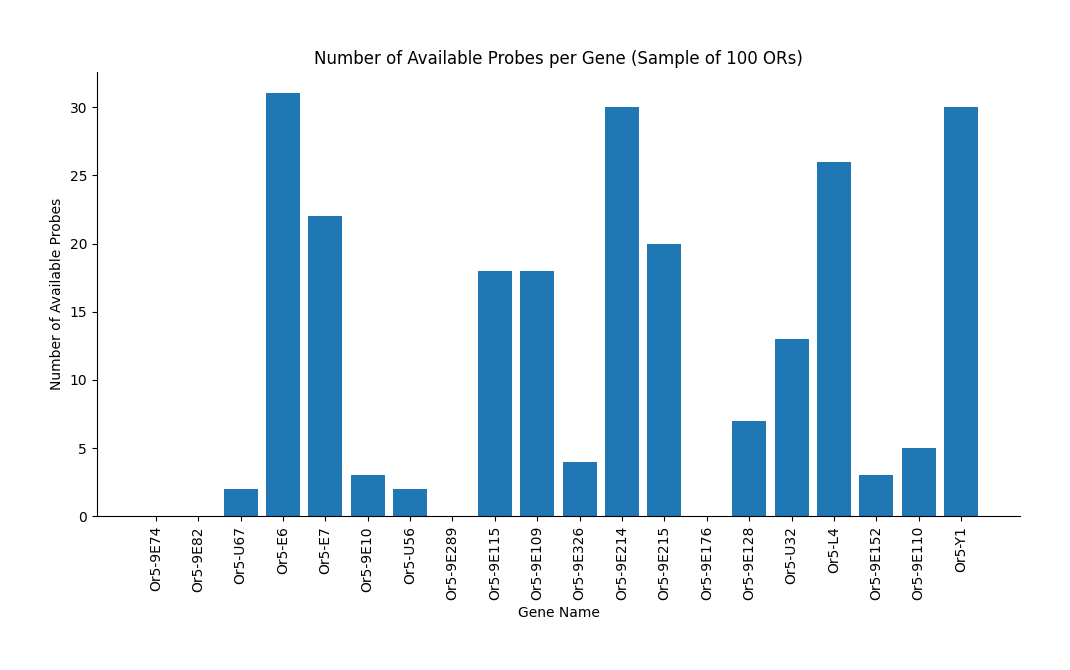

In [8]:
f, ax = plt.subplots(figsize=(10, 6))
ax.bar(or_db['gene_name'], or_db['n_probes'])
ax.set_xlabel("Gene Name")
ax.set_ylabel("Number of Available Probes")
ax.set_title("Number of Available Probes per Gene (Sample of 100 ORs)")
ax.tick_params(axis='x', rotation=90)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()